# Projet Reporting et Restitution
## Membres du groupe :
### Hugo HOUNTONDJI
### LO Maty
### HU Angel
### PASINI Giorgio

Hypothèses à verifier
- Les morceaux placés en début de playlist ont une plus grande durée moyenne.
- Un album est rarement représenté par plus de 2 morceaux dans une playlist (les chanson normalement arrivent d'album differents)
- Les playlists contiennent plus d’albums uniques que d’artistes (pour un artiste normalement il y a plusieurs album).
- Les playlists avec plus de 50 morceaux ont une diversité d'artistes plus élevée (plus de num_artists).

## 1_nettoyage

Ce script a pour objectif de :
Charger les fichiers de données brutes (JSON du MPD).
Aplatir la structure pour avoir une ligne par piste de playlist.
Nettoyer les données (gestion des valeurs nulles, des doublons, conversion des types).
Sauvegarder le jeu de données propre dans un fichier CSV (`alcrowd_cleaned.csv`) qui servira de base pour toutes les analyses futures.


In [1]:
# Importation des bibliothèques
import pandas as pd
import os
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
def write_csv_data_from_json(source_data_path, cleaned_data_path, number_of_files_limit = 5):
    print("--- Début du nettoyage et chargement ---")
    
    # Chargement et fusion des données
    # base_dir = os.path.dirname(os.path.abspath(__file__)) # cette version est pour le .py

    # Chargement des fichiers JSON
    json_files = glob.glob(os.path.join(source_data_path, 'mpd.slice.*.json'))
    all_playlists = []
    for file in json_files[0:number_of_files_limit]:
        with open(file, 'r') as f:
            print(f"Chargement du file {file}")
            data = json.load(f)
            all_playlists.extend(data['playlists'])

    print(f"Chargement de {len(all_playlists)} playlists")

    # Aplatissement des données (une ligne par piste)
    if all_playlists:
        mpd_df = pd.DataFrame(all_playlists)
        mpd_exploded_df = mpd_df.explode('tracks')
        tracks_df = mpd_exploded_df['tracks'].apply(pd.Series)
        mpd_flat_df = pd.concat([mpd_exploded_df.drop(columns=['tracks']), tracks_df], axis=1)
        
        # Renommage des colonnes pour éviter les conflits
        if 'duration_ms' in mpd_flat_df.columns:
            cols = mpd_flat_df.columns.tolist()
            idx_playlist_duration = cols.index('duration_ms')
            cols[idx_playlist_duration] = 'playlist_duration_ms'
            if 'duration_ms' in cols[idx_playlist_duration + 1:]:
                idx_track_duration = cols.index('duration_ms', idx_playlist_duration + 1)
                cols[idx_track_duration] = 'track_duration_ms'
            mpd_flat_df.columns = cols
        
        df = mpd_flat_df.copy()
        print("DataFrame aplati créé avec succès.")
        print("Dimensions initiales :", df.shape)
    else:
        raise ValueError("Aucune playlist n'a été chargée. Vérifiez les fichiers JSON.")
    
    # Nettoyage des données
    print("\nÉtape 3: Début du nettoyage des données.")

    #################################################################################################

    # Gestion des valeurs manquantes
    print(f"Lignes avant suppression des NaN ('track_uri'): {len(df)}")
    df.dropna(subset=['track_uri'], inplace=True)
    print(f"Lignes après suppression des NaN ('track_uri'): {len(df)}")

    if 'description' in df.columns:
        df.drop(columns=['description'], inplace=True)
        print("Colonne 'description' supprimée.")

    # Le '0' peut apparaître si une colonne 'tracks' était vide.
    if '0' in df.columns and df['0'].isnull().all():
        df.drop(columns=['0'], inplace=True)

    #################################################################################################

    # Gestion des doublons
    print(f"Lignes avant suppression des doublons : {len(df)}")
    df.drop_duplicates(inplace=True)
    print(f"Lignes après suppression des doublons : {len(df)}")

    #################################################################################################

    # Conversion des types de données
    print("Conversion du type de 'modified_at' en datetime.")
    df['modified_at'] = pd.to_datetime(df['modified_at'], unit='s')

    # Conversion de la durée en minutes
    # je commente parce que j'ai déjà fait la conversion dans le notebook
    df['playlist_duration_ms'] = df['playlist_duration_ms'] / 60000 # 1000 ms/s * 60 s/m 
    df['track_duration_ms'] = df['track_duration_ms'] / 60000 # 1000 ms/s * 60 s/m

    df.rename(columns={
        'playlist_duration_ms': 'playlist_duration_minutes',
        'track_duration_ms': 'track_duration_minutes'
    }, inplace=True)
    df.head(5)

    
    print("Dimensions finales après nettoyage :", df.shape)


    #################################################################################################

    # Sauvegarde des données nettoyées
    
    df.to_csv(cleaned_data_path, index=False, encoding='utf-8')

    print(f"\nNettoyage terminé")
    print(f"Les données nettoyées ont été sauvegardées ici : {cleaned_data_path}")

    return df

## analyse_exploratoire
Ce script a pour objectif de réaliser une analyse exploratoire sur les données nettoyées.
Charger le jeu de données nettoyé (`alcrowd_cleaned.csv`).
Réaliser une analyse univariée pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
Réaliser une analyse bivariée pour explorer les relations entre les variables (matrice de corrélation).

In [3]:
base_dir = os.getcwd() # cette version est pour le notebook
alcrowd_path = os.path.join(base_dir, 'alcrowd')
source_data_path = os.path.join(alcrowd_path, 'source_data/spotify_million_playlist_dataset/data')

output_dir = os.path.join(alcrowd_path, 'output')
os.makedirs(output_dir, exist_ok=True)

cleaned_data_path = os.path.join(output_dir, 'alcrowd_cleaned.csv')

#df = write_csv_data_from_json(source_data_path, cleaned_data_path, number_of_files_limit=5)
#print("Colonnes du DataFrame :", df.columns.tolist())



In [4]:
print("Débutons notre analyse exploratoire")

# Création d'un dossier de sortie dédié pour les graphiques
output_dir = os.path.join(base_dir, 'alcrowd', 'analyse_exploratoire_plots')
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(cleaned_data_path):
    raise FileNotFoundError(f"Le fichier de données nettoyées n'a pas été trouvé : {cleaned_data_path}\n"
                            "Pensez à dans un premier temps, exécuter le script 'de nettoyage des données.")

df = pd.read_csv(cleaned_data_path)
print(f"Données chargées depuis '{cleaned_data_path}'.")


Débutons notre analyse exploratoire
Données chargées depuis 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\output\alcrowd_cleaned.csv'.


In [5]:
df

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_minutes,num_artists,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_minutes,album_name
0,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,3.781050,The Cookbook
1,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,3.313333,In The Zone
2,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,3.932217,Dangerously In Love (Alben für die Ewigkeit)
3,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,4.454433,Justified
4,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,3.793333,Hot Shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006738,Country jams,False,9999,2017-04-23,55,41,3,22,193.40165,33,50,Keith Urban,spotify:track:6ZOPiKQeibCn7fP8dncucL,spotify:artist:0u2FHSq3ln94y5Q57xazwf,Blue Ain't Your Color,spotify:album:1r7ABqzNXQnUPAH3ZjrHMn,3.843333,Ripcord
2006739,Country jams,False,9999,2017-04-23,55,41,3,22,193.40165,33,51,Dustin Lynch,spotify:track:7pxhKtuTwofDIdgHx2DcVK,spotify:artist:1dID9zgn0OV0Y8ud7Mh2tS,Seein' Red,spotify:album:23cuZhPWDfX1uKD4qwuv7t,3.248217,Current Mood
2006740,Country jams,False,9999,2017-04-23,55,41,3,22,193.40165,33,52,Sam Hunt,spotify:track:7mldq42yDuxiUNn08nvzHO,spotify:artist:2kucQ9jQwuD8jWdtR9Ef38,Body Like A Back Road,spotify:album:2N7kidh1wA9EoLdf16QWrz,2.756433,Body Like A Back Road
2006741,Country jams,False,9999,2017-04-23,55,41,3,22,193.40165,33,53,Little Big Town,spotify:track:23TxRN09aR1RB0G0tFoT0b,spotify:artist:3CygdxquGHurS7f9LjNLkv,Better Man,spotify:album:2aQOzEjLzPkffXDwREXdAh,4.385333,The Breaker


In [6]:
# Analyse Exploratoire (EDA)
print("\nDébut de l'analyse exploratoire.")

# A. Analyse univariée
print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())


Début de l'analyse exploratoire.

Statistiques descriptives des colonnes numériques :
                pid    num_tracks    num_albums  num_followers     num_edits  \
count  2.006743e+06  2.006743e+06  2.006743e+06   2.006743e+06  2.006743e+06   
mean   1.503635e+04  1.100180e+02  7.894603e+01   3.523630e+00  2.817886e+01   
std    8.669296e+03  6.295632e+01  4.810815e+01   1.414497e+02  2.824885e+01   
min    0.000000e+00  5.000000e+00  2.000000e+00   1.000000e+00  2.000000e+00   
25%    7.502000e+03  5.700000e+01  4.000000e+01   1.000000e+00  7.000000e+00   
50%    1.507900e+04  1.000000e+02  7.000000e+01   1.000000e+00  1.800000e+01   
75%    2.253900e+04  1.570000e+02  1.100000e+02   2.000000e+00  4.000000e+01   
max    2.999900e+04  2.500000e+02  2.330000e+02   1.584200e+04  1.780000e+02   

       playlist_duration_minutes   num_artists           pos  \
count               2.006743e+06  2.006743e+06  2.006743e+06   
mean                4.309224e+02  5.833492e+01  5.450902e+01   


Graphiques des distributions univariées sauvegardés : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_1_distributions_numeriques.png


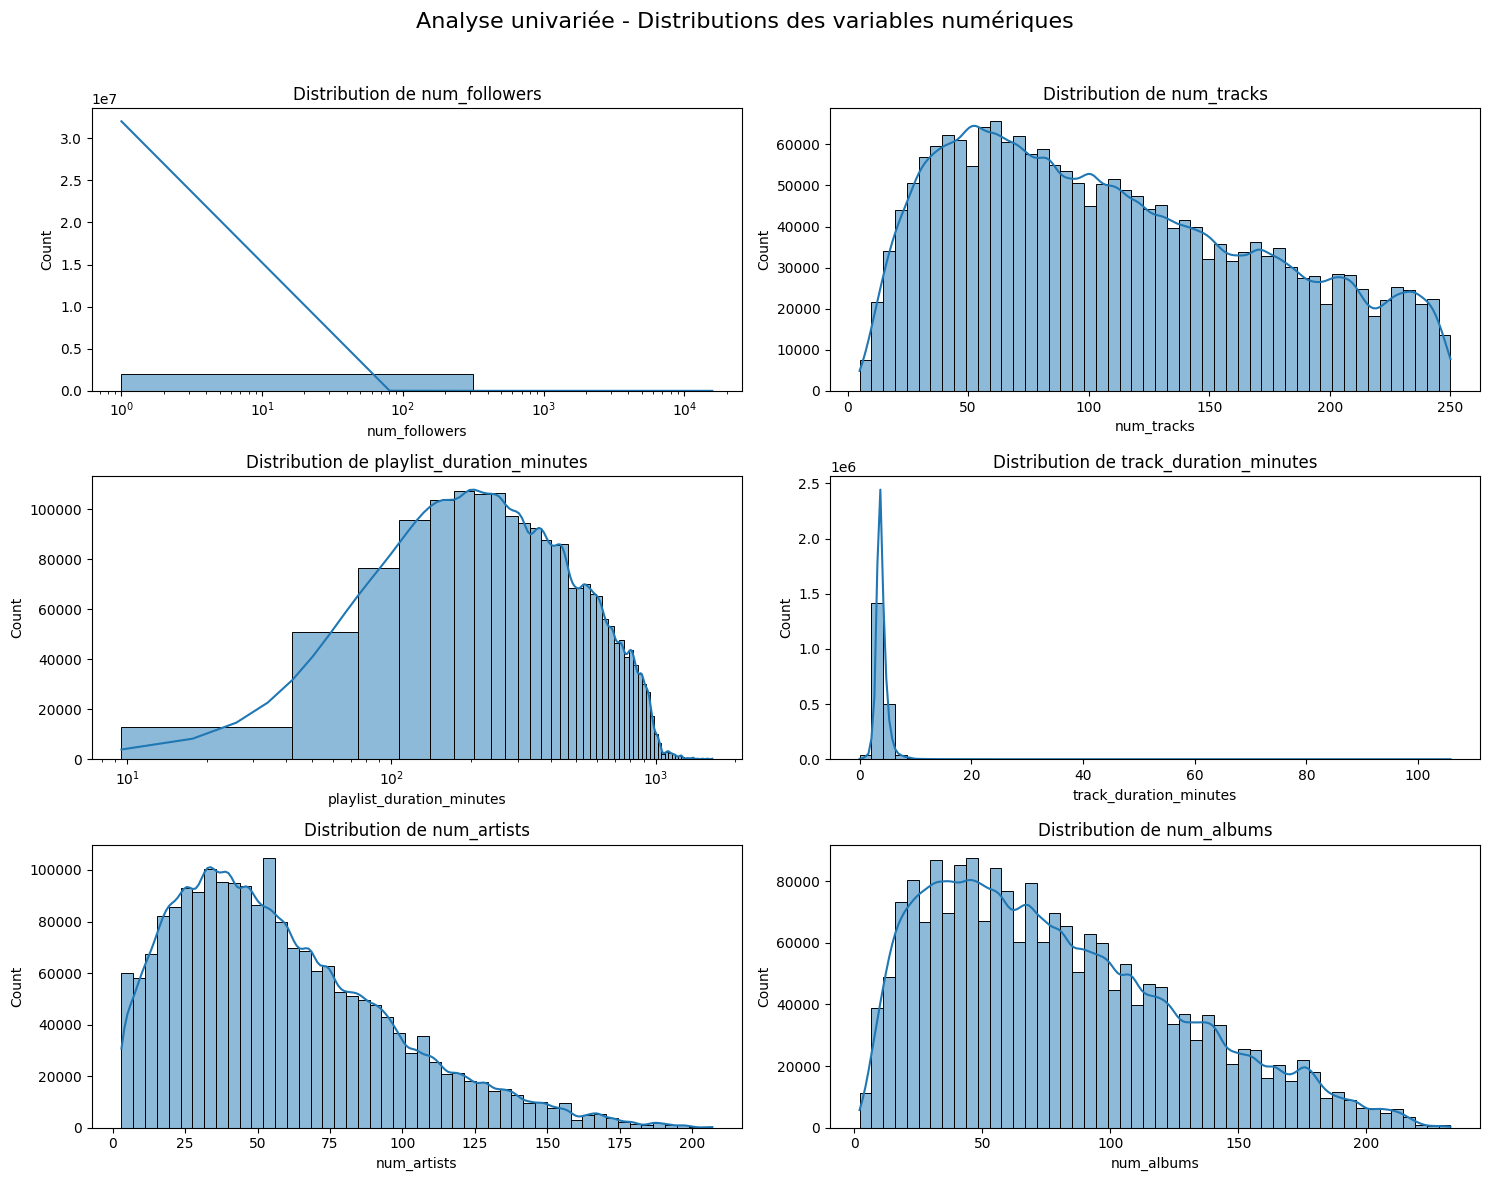

In [7]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'playlist_duration_minutes', 'track_duration_minutes', 'num_artists', 'num_albums']

plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univariée - Distributions des variables numériques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'échelle log est utile pour les données très asymétriques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univariées sauvegardés : {univariate_plot_path}")
plt.show()
plt.close()


Boxplots sauvegardés : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_2_boxplots_numeriques.png


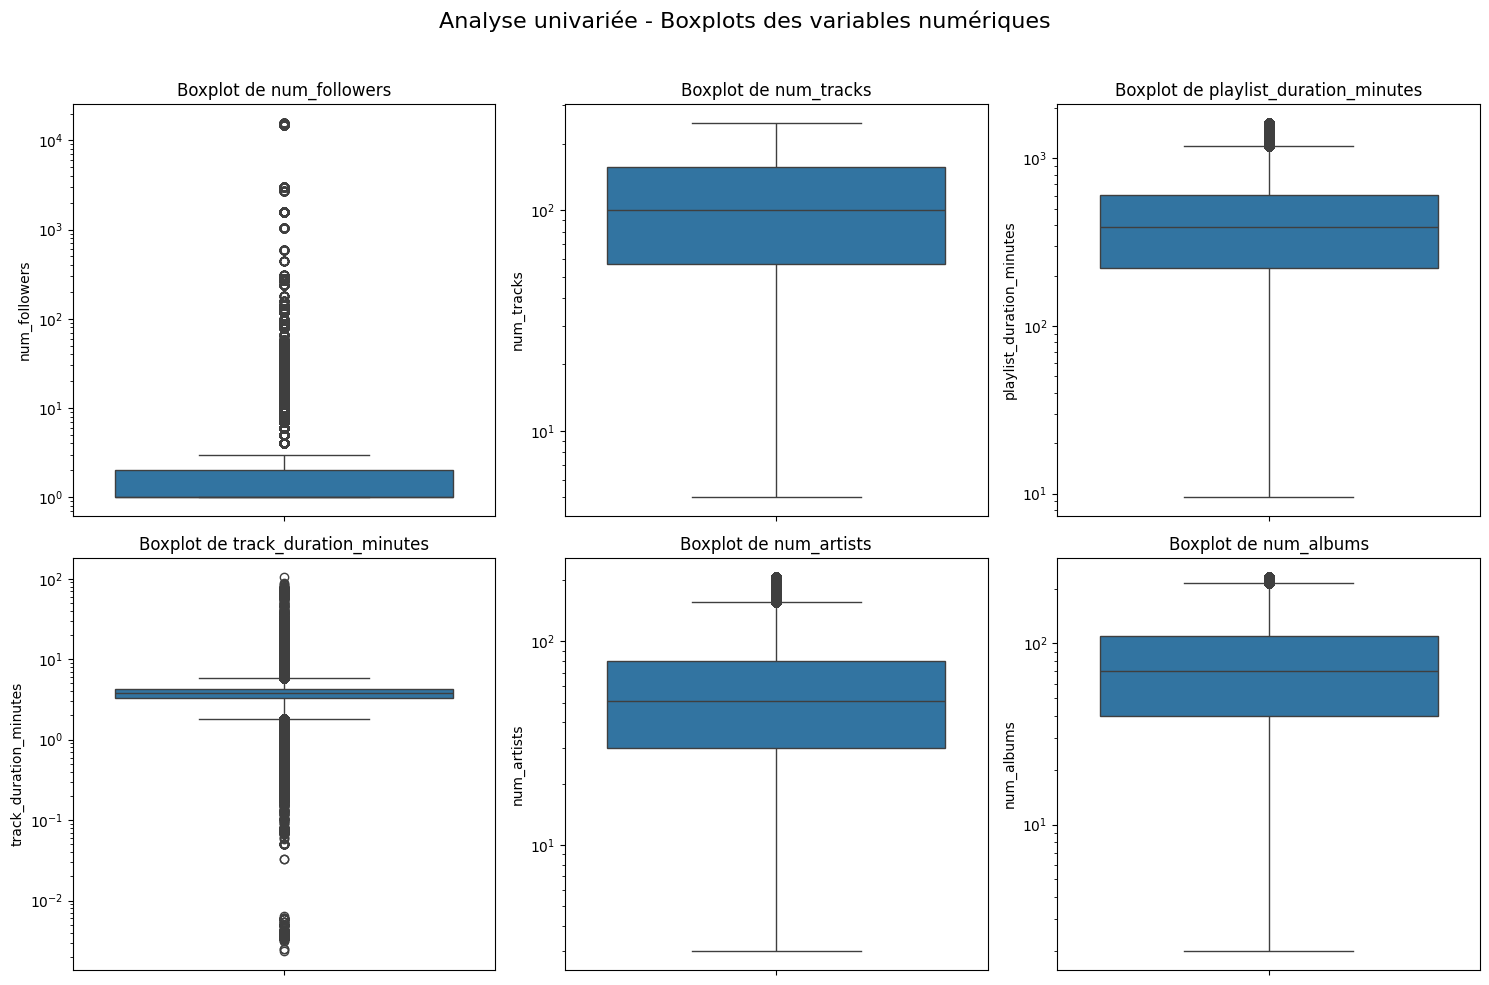

In [8]:
# Boxplots pour les variables numériques
plt.figure(figsize=(15, 10))
plt.suptitle('Analyse univariée - Boxplots des variables numériques', fontsize=16)

for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.yscale('log')

plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_box_path = os.path.join(output_dir, 'univar_2_boxplots_numeriques.png')
plt.savefig(univariate_box_path)
print(f"Boxplots sauvegardés : {univariate_box_path}")
plt.show()
plt.close()

C:\Users\giorg\AppData\Local\Temp\ipykernel_13928\1432556163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


Graphique 'Top 20 des artistes les plus fréquents' sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_3_top20_artistes.png


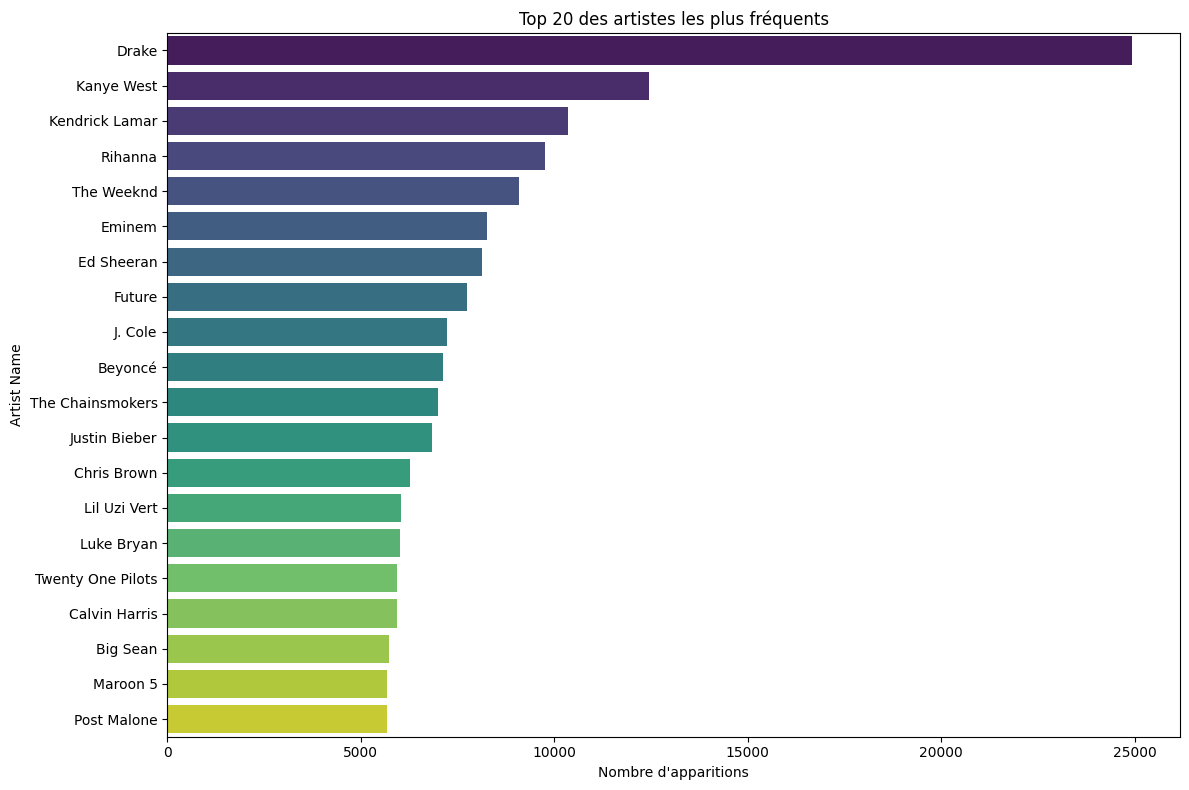

C:\Users\giorg\AppData\Local\Temp\ipykernel_13928\1432556163.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')


Graphique 'Top 20 des albums les plus fréquents' sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_4_top20_albums.png


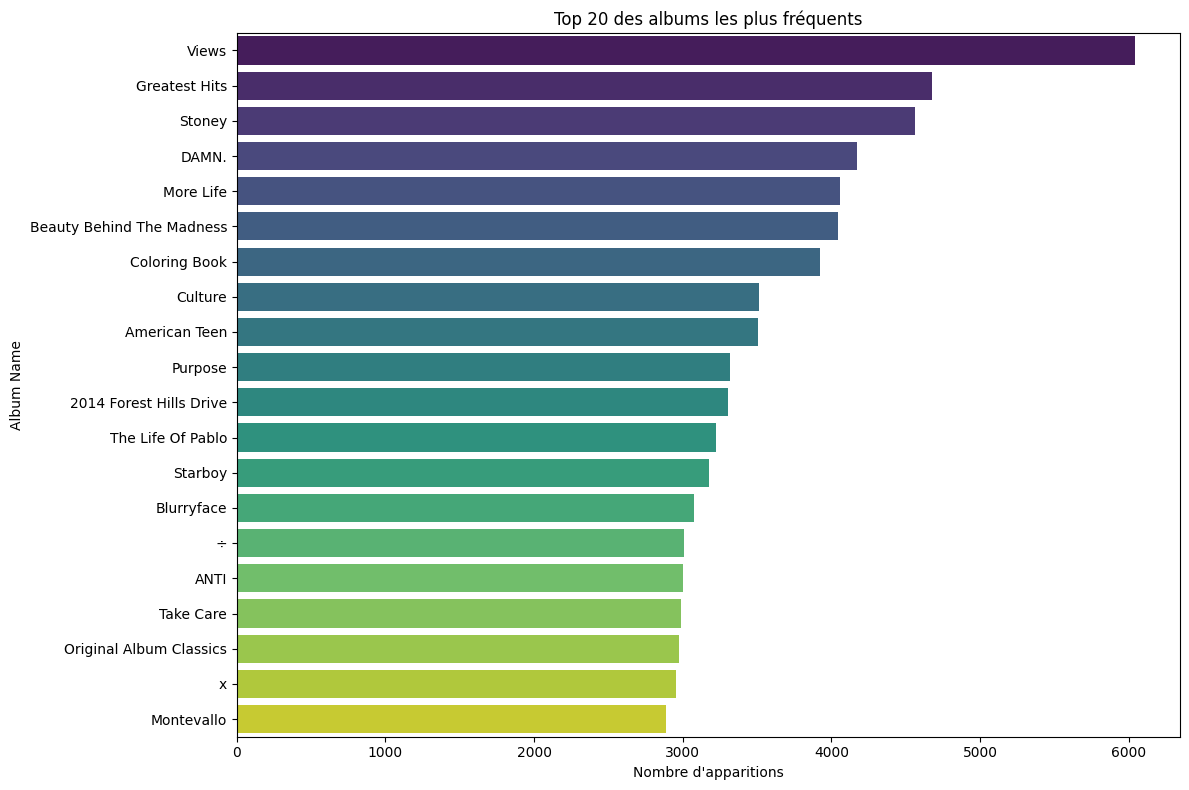

In [9]:
# Analyse des variables catégorielles (Top 20)
def plot_top_n(data, column, n, title, path):
    plt.figure(figsize=(12, 8))
    top_n = data[column].value_counts().nlargest(n)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(title)
    plt.xlabel("Nombre d'apparitions")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(path)
    print(f"Graphique '{title}' sauvegardé : {path}")
    plt.show()
    plt.close()

plot_top_n(df, 'artist_name', 20, 'Top 20 des artistes les plus fréquents', os.path.join(output_dir, 'univar_3_top20_artistes.png'))
plot_top_n(df, 'album_name', 20, 'Top 20 des albums les plus fréquents', os.path.join(output_dir, 'univar_4_top20_albums.png'))

Nuage de mots sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_5_wordcloud_noms_playlist.png


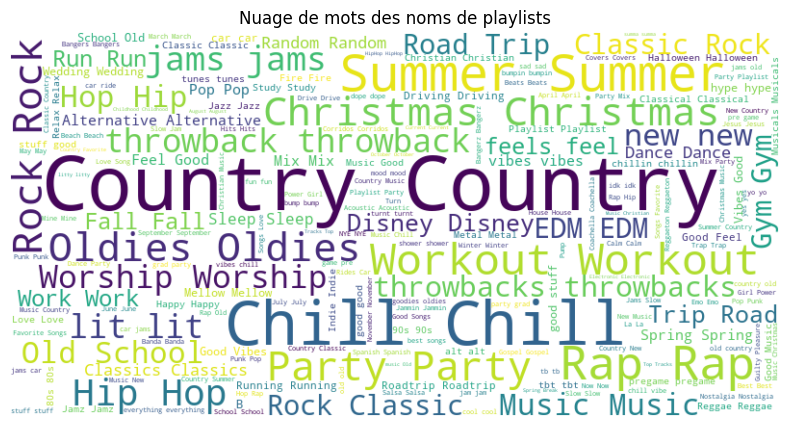

In [10]:
# Nuage de mots pour les noms de playlists
playlist_names = ' '.join(df['name'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(playlist_names)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des noms de playlists')
wordcloud_path = os.path.join(output_dir, 'univar_5_wordcloud_noms_playlist.png')
plt.savefig(wordcloud_path)
print(f"Nuage de mots sauvegardé : {wordcloud_path}")
plt.show()
plt.close()

Matrice de corrélation sauvegardée : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_1_matrice_correlation.png


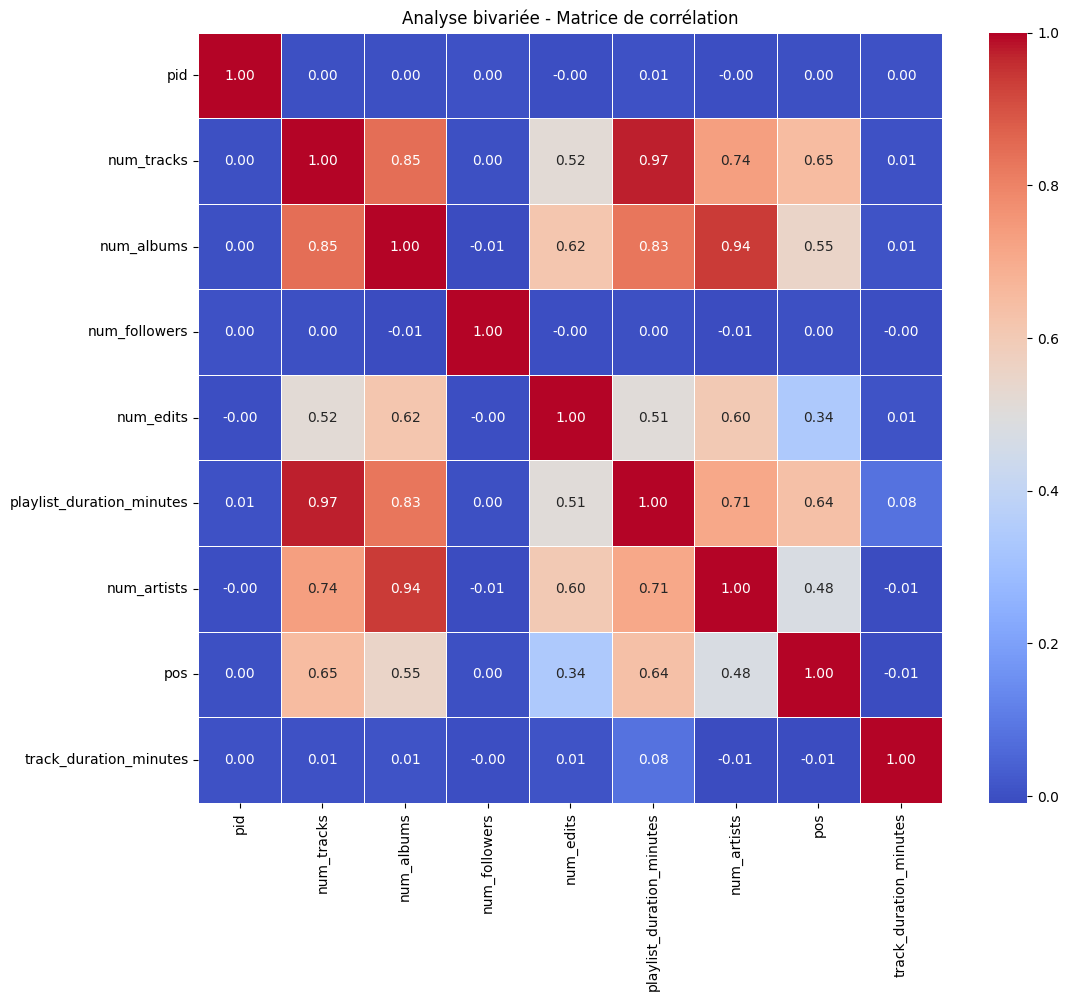

In [11]:
# B. Analyse bivariée
# Matrice de corrélation
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Analyse bivariée - Matrice de corrélation')
bivariate_plot_path = os.path.join(output_dir, 'bivar_1_matrice_correlation.png')
plt.savefig(bivariate_plot_path)
print(f"Matrice de corrélation sauvegardée : {bivariate_plot_path}")
plt.show()
plt.close()

In [ ]:
# Pairplot pour les variables clés
pairplot_cols = ['num_followers', 'num_tracks', 'track_duration_minutes', 'num_artists']
sns.pairplot(df[pairplot_cols].dropna())
plt.suptitle('Analyse bivariée - Pairplot des variables clés', y=1.02)
pairplot_path = os.path.join(output_dir, 'bivar_2_pairplot.png')
plt.savefig(pairplot_path)
print(f"Pairplot sauvegardé : {pairplot_path}")
plt.show()
plt.close()

KeyboardInterrupt: 

Nuage de points sauvegardé : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_3_scatter_pistes_followers.png


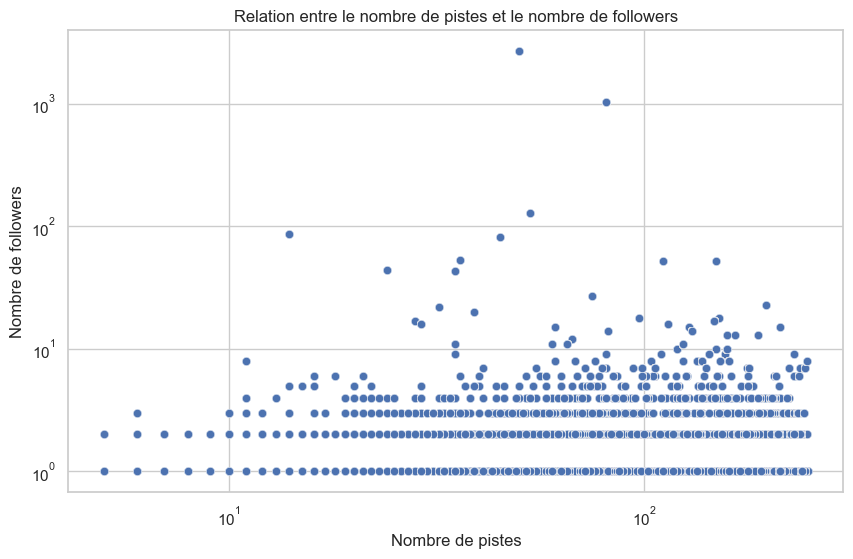


--- Analyse exploratoire terminée ---
Tous les graphiques ont été sauvegardés dans : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots


In [ ]:
# Scatter plot spécifique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_tracks', y='num_followers', alpha=0.5)
plt.title('Relation entre le nombre de pistes et le nombre de followers')
plt.xlabel('Nombre de pistes')
plt.ylabel('Nombre de followers')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
scatter_path = os.path.join(output_dir, 'bivar_3_scatter_pistes_followers.png')
plt.savefig(scatter_path)
print(f"Nuage de points sauvegardé : {scatter_path}")
plt.show()
plt.close()

print("\n--- Analyse exploratoire terminée ---")
print(f"Tous les graphiques ont été sauvegardés dans : {output_dir}")

In [ ]:
# df = pd.read_csv("alcrowd/alcrowd_cleaned.csv") 
df = pd.read_csv(cleaned_data_path)

# Trouver les 3000 premiers pid (triés)
first_3000_pids = sorted(df['pid'].unique())[:3000]

# Filtrer les morceaux qui appartiennent à ces playlists
df_3000 = df[df['pid'].isin(first_3000_pids)].copy()

In [ ]:
df_3000

,name,collaborative,pid,modified_at,num_tracks,num_albums,num_followers,num_edits,playlist_duration_minutes,num_artists,pos,artist_name,track_uri,artist_uri,track_name,album_uri,track_duration_minutes,album_name
0,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,0,Missy Elliott,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI,spotify:artist:2wIVse2owClT7go1WT98tk,Lose Control (feat. Ciara & Fat Man Scoop),spotify:album:6vV5UrXcfyQD1wu4Qo2I9K,3.781050,The Cookbook
1,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,1,Britney Spears,spotify:track:6I9VzXrHxO9rA9A5euc8Ak,spotify:artist:26dSoYclwsYLMAKD3tpOr4,Toxic,spotify:album:0z7pVBGOD7HCIB7S8eLkLI,3.313333,In The Zone
2,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,2,Beyoncé,spotify:track:0WqIKmW4BTrj3eJFmnCKMv,spotify:artist:6vWDO969PvNqNYHIOW5v0m,Crazy In Love,spotify:album:25hVFAxTlDvXbx2X2QkUkE,3.932217,Dangerously In Love (Alben für die Ewigkeit)
3,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,3,Justin Timberlake,spotify:track:1AWQoqb9bSvzTjaLralEkT,spotify:artist:31TPClRtHm23RisEBtV3X7,Rock Your Body,spotify:album:6QPkyl04rXwTGlGlcYaRoW,4.454433,Justified
4,Throwbacks,False,0,2017-04-29,52,47,1,6,192.20690,37,4,Shaggy,spotify:track:1lzr43nnXAijIGYnCT8M8H,spotify:artist:5EvFsr3kj42KNv97ZEnqij,It Wasn't Me,spotify:album:6NmFmPX56pcLBOFMhIiKvF,3.793333,Hot Shot
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199869,Starting Over,False,2999,2014-12-13,71,67,1,28,271.73765,62,66,Dominic Cooper,spotify:track:2sxi3UJLbsIs6p281rARgi,spotify:artist:0F6wZIBwxstvRk9eQtpvOo,"Lay All Your Love On Me - From ""Mamma Mia!"" So...",spotify:album:5KhzAHMfdnBORoub8UYPDC,4.490667,Mamma Mia! The Movie Soundtrack
199870,Starting Over,False,2999,2014-12-13,71,67,1,28,271.73765,62,67,Mikky Ekko,spotify:track:3D1Kbd2pAO9chkd5aEP6q5,spotify:artist:1buzCmyYZE4kcdLRudsb8V,Mourning Doves,spotify:album:6ZM59O9R5zjawLVwCMD2zJ,4.310883,Time
199871,Starting Over,False,2999,2014-12-13,71,67,1,28,271.73765,62,68,Brandi Carlile,spotify:track:2zPaWxKdwaro3UmZ6ZVwfA,spotify:artist:2sG4zTOLvjKG1PSoOyf5Ej,Touching the Ground,spotify:album:1NhFksWs1Nsz6wQI8ysTkv,3.279333,Give Up The Ghost
199872,Starting Over,False,2999,2014-12-13,71,67,1,28,271.73765,62,69,Doom & Gloom,spotify:track:4P75K3ruHef0eP6GSJkncx,spotify:artist:61l8LBmASmaPsm0q7rQF2i,And I Love Her,spotify:album:1wgGprEG5HgYbhFq3eMmtO,3.393483,Beatles Reimagined


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334487 entries, 0 to 334486
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   name                       334487 non-null  object 
 1   collaborative              334487 non-null  bool   
 2   pid                        334487 non-null  int64  
 3   modified_at                334487 non-null  object 
 4   num_tracks                 334487 non-null  int64  
 5   num_albums                 334487 non-null  int64  
 6   num_followers              334487 non-null  int64  
 7   num_edits                  334487 non-null  int64  
 8   playlist_duration_minutes  334487 non-null  float64
 9   num_artists                334487 non-null  int64  
 10  pos                        334487 non-null  int64  
 11  artist_name                334487 non-null  object 
 12  track_uri                  334487 non-null  object 
 13  artist_uri                 33

In [ ]:
df.describe()

,pid,num_tracks,num_albums,num_followers,num_edits,playlist_duration_minutes,num_artists,pos,track_duration_minutes
count,334487.000000,334487.000000,334487.000000,334487.000000,334487.000000,334487.000000,334487.000000,334487.000000,334487.000000
mean,2503.224391,109.786422,78.701979,2.430656,28.382978,428.837999,58.166539,54.393211,3.907882
std,1446.691100,62.427929,47.254599,36.828240,28.596505,250.220894,36.520193,47.993992,1.244270
min,0.000000,5.000000,2.000000,1.000000,2.000000,15.397983,3.000000,0.000000,0.000000
25%,1247.000000,58.000000,41.000000,1.000000,7.000000,221.565117,30.000000,17.000000,3.304883
50%,2494.000000,101.000000,71.000000,1.000000,18.000000,392.521067,51.000000,40.000000,3.749333
75%,3775.000000,157.000000,111.000000,2.000000,39.000000,603.893317,79.000000,79.000000,4.313767
max,4999.000000,248.000000,233.000000,2699.000000,178.000000,1384.994417,199.000000,247.000000,87.996133


### PCA

In [ ]:
# Construction de la matrice playlist × album
# pivot_df = df.pivot_table(index='pid', columns='album_name', values='track_uri', aggfunc='count', fill_value=0)
df_numerical_columns = [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]
df_numerical_columns


['num_followers', 'num_artists']

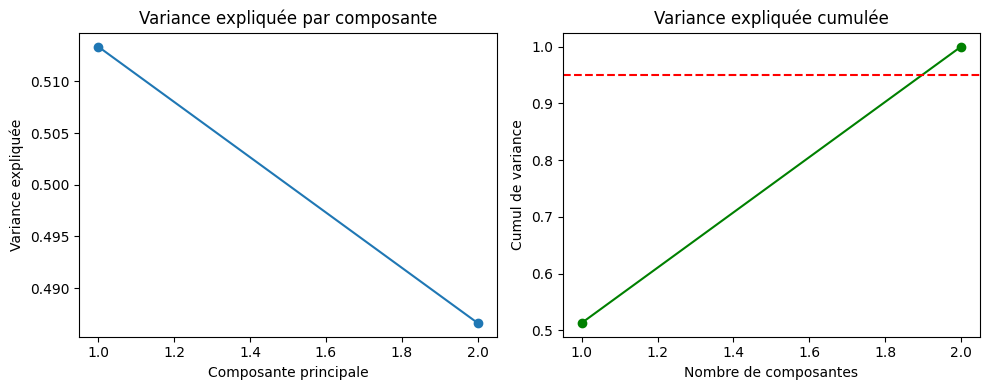

In [ ]:
# Standardisation
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pivot_df)
X_scaled = scaler.fit_transform(df[df_numerical_columns])

# Instanciation de l'objet PCA
pca = PCA()

# Application de l'ACP
X_pca = pca.fit_transform(X_scaled)

# Extraction des variances expliquées
explained_variance = pca.explained_variance_ratio_
#print(explained_variance)
cumulative_variance = explained_variance.cumsum()
#print(cumulative_variance)

plt.figure(figsize=(10, 4))

# Variance expliquée par composante
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Variance expliquée par composante")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée")

# Variance cumulée
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='green')
plt.axhline(0.95, color='red', linestyle='--')
plt.title("Variance expliquée cumulée")
plt.xlabel("Nombre de composantes")
plt.ylabel("Cumul de variance")

plt.tight_layout()
plt.show()

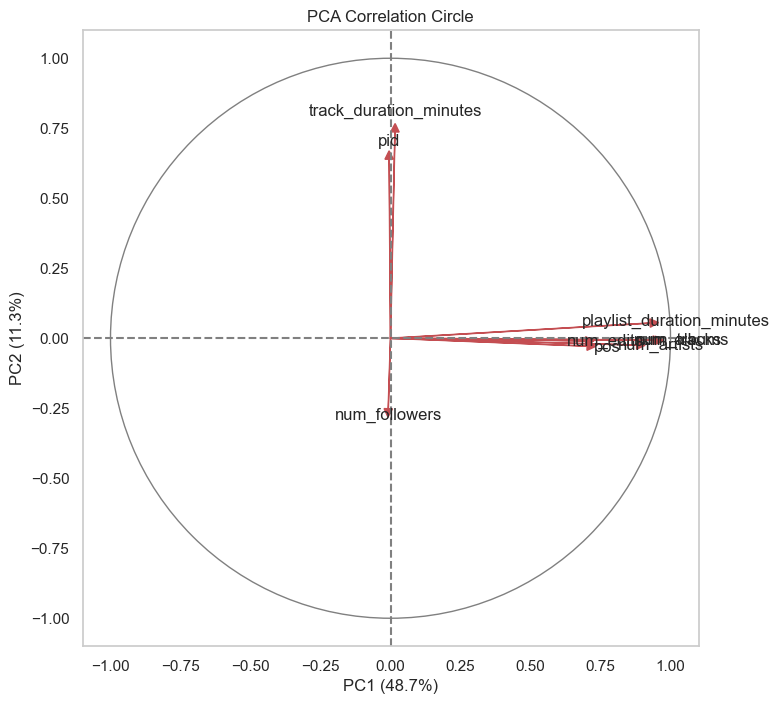

In [ ]:
# Perform PCA
pca = PCA(n_components=2)

# Application de l'ACP
X_pca = pca.fit(X_scaled)

# Compute correlations between original features and PCs
correlations = X_pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot the correlation circle
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)

for i, (x, y) in enumerate(correlations):
    plt.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, color='r')
    plt.text(x * 1.1, y * 1.1, df_numerical_columns[i], ha='center', va='center')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f"PC1 ({X_pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({X_pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("PCA Correlation Circle")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


Le circle de correlation de l'ACP semble avoir comme axe principal une dimension que on pourrait appeler ""

## Hypothèses
Un album est rarement représenté par plus de 2 morceaux dans une playlist

### Maty

In [ ]:
# Construction de la matrice playlist × album
pivot_df = df.pivot_table(index='pid', columns='album_name', values='track_uri', aggfunc='count', fill_value=0)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(pivot_df)


### K-means : commentaire Giorgio : est-ce que nous en avons besoin comme que nous avons déjà fait la k-means dans les analyses préliminaires ?

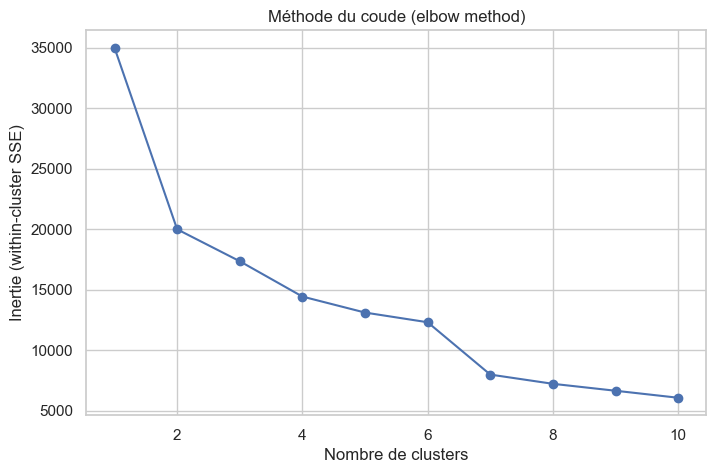

In [ ]:
# 1. Calcul de la variable max_tracks_per_album (nombre maximum de morceaux provenant du même album dans la playlist)
max_per_album = df.groupby(['pid', 'album_name']).size().reset_index(name='count')
max_tracks_per_album = max_per_album.groupby('pid')['count'].max().reset_index(name='max_tracks_per_album')

# 2. Agrégation des autres infos playlist
playlist_features = df.groupby('pid').agg({
    'num_tracks': 'first',
    'num_albums': 'first',
    'num_artists': 'first',
    'num_followers': 'first',
    'num_edits': 'first',
    'playlist_duration_minutes': 'first'
}).reset_index()

# 3. Fusion de la variable max_tracks_per_album
playlist_df = pd.merge(playlist_features, max_tracks_per_album, on='pid')

# 4. Sélection des variables pour le clustering (inclut maintenant l’hypothèse)
features = ['num_tracks', 'num_albums', 'num_artists', 'num_followers', 
            'num_edits', 'playlist_duration_minutes', 'max_tracks_per_album']
X = playlist_df[features]

# 5. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Méthode du coude
inertia = []
K_range = range(1, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Tracé de la courbe du coude
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie (within-cluster SSE)')
plt.title("Méthode du coude (elbow method)")
plt.grid(True)
plt.show()


In [ ]:
#k optimal = 4
kmeans = KMeans(n_clusters=4, random_state=42)
playlist_df['cluster'] = kmeans.fit_predict(X_scaled)

C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\2697006595.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(x='cluster', y='max_tracks_per_album', data=playlist_df, jitter=0.3, alpha=0.6, palette='Set2')


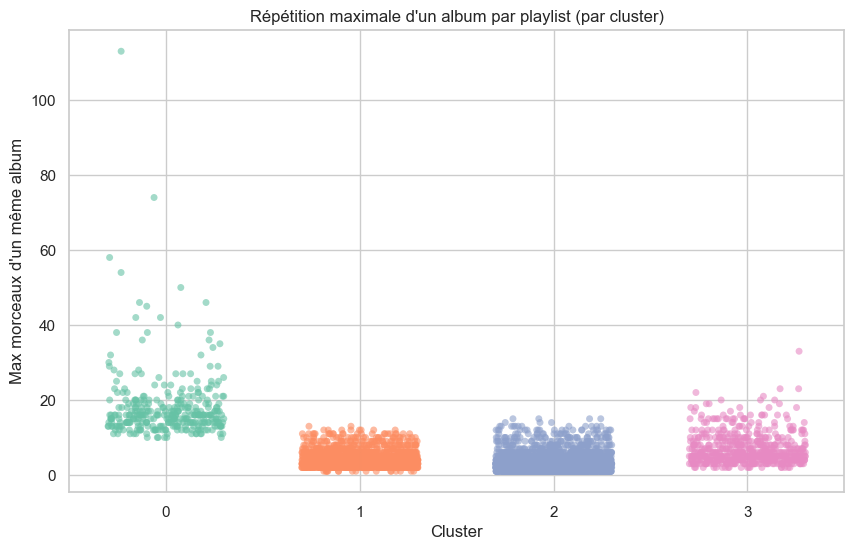

In [ ]:
plt.figure(figsize=(10, 6))
sns.stripplot(x='cluster', y='max_tracks_per_album', data=playlist_df, jitter=0.3, alpha=0.6, palette='Set2')
plt.title("Répétition maximale d'un album par playlist (par cluster)")
plt.xlabel("Cluster")
plt.ylabel("Max morceaux d'un même album")
plt.grid(True)
plt.show()

Clusters 0 et 1 : majorité des points ≤ 10 → les playlists de ces groupes peuvent confirmer l'hypothèse.
Cluster 2 : dispersion plus large, quelques points dépassent 20, 40, 60, jusqu'à 100 morceaux du même album → forte répétition dans certaines playlists → contredit partiellement l’hypothèse pour ce groupe.
Cluster 3 : un seul point (cas extrême isolé ?), avec répétition de 2 morceaux → cohérent avec l’hypothèse.

En conclusion, on peut considérer que l'hypothèse est vérifiée car elle reste valide dans la plupart des cas.

## Visualisation

Text(0.5, 0, 'Albums différents')

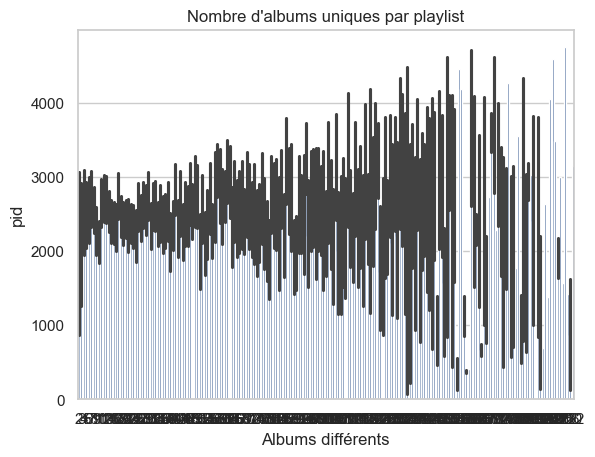

In [ ]:
albums_per_playlist = df.groupby('pid')['album_name'].nunique()
#sns.histplot(albums_per_playlist, bins=30)
sns.barplot(y=albums_per_playlist.index, x=albums_per_playlist.values)
plt.title("Nombre d'albums uniques par playlist")
plt.xlabel("Albums différents")

In [ ]:
albums_per_playlist = df.groupby('pid')['album_name'].nunique()
print(albums_per_playlist)
print(albums_per_playlist.index)

pid
0        44
1        23
2        51
3       107
4        16
       ... 
4995     35
4996     40
4997     11
4998    133
4999     20
Name: album_name, Length: 5000, dtype: int64
Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
       ...
       4990, 4991, 4992, 4993, 4994, 4995, 4996, 4997, 4998, 4999],
      dtype='int64', name='pid', length=5000)


In [ ]:
# Nombre de playlists différentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("🎤 Top 3 artistes présents dans le plus grand nombre de playlists :")
print(artist_playlist_counts)

🎤 Top 3 artistes présents dans le plus grand nombre de playlists :
artist_name
Drake         949
Rihanna       728
Kanye West    696
Name: pid, dtype: int64


In [ ]:
# Nombre de playlists différentes par album
album_playlist_counts = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("\n💿 Top 3 albums présents dans le plus grand nombre de playlists :")
print(album_playlist_counts)


💿 Top 3 albums présents dans le plus grand nombre de playlists :
album_name
Greatest Hits    481
Views            449
Stoney           420
Name: pid, dtype: int64


C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\3849484129.py:36: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\giorg\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


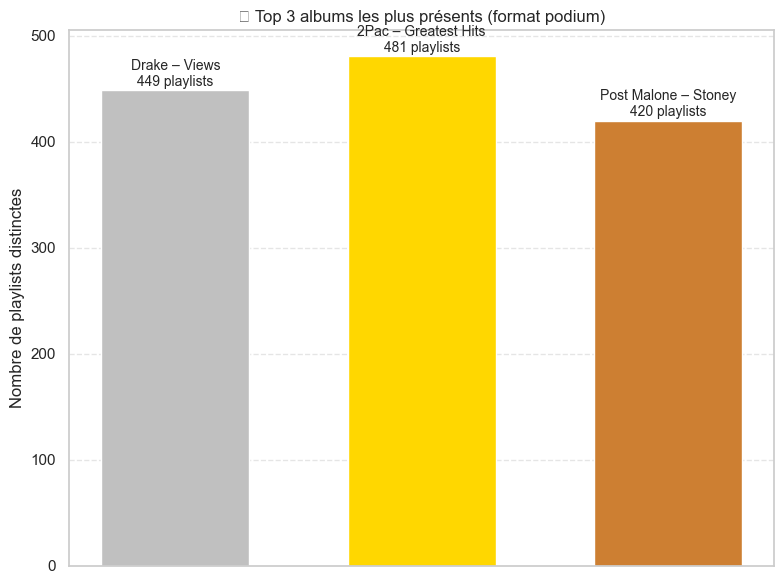

In [ ]:
top_albums = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)
top_album_names = top_albums.index.tolist()

album_artist_map = (
    df[df['album_name'].isin(top_album_names)]
    .groupby('album_name')['artist_name']
    .agg(lambda x: x.mode().iloc[0])  # artiste le plus fréquent pour l’album
)
album_labels = [f"{album_artist_map[album]} – {album}" for album in top_album_names]

# Données du podium
scores = top_albums.values
labels = album_labels

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e à gauche, 2 = 3e à droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalisées (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libellés)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("🏆 Top 3 albums les plus présents (format podium)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\377170429.py:29: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\giorg\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


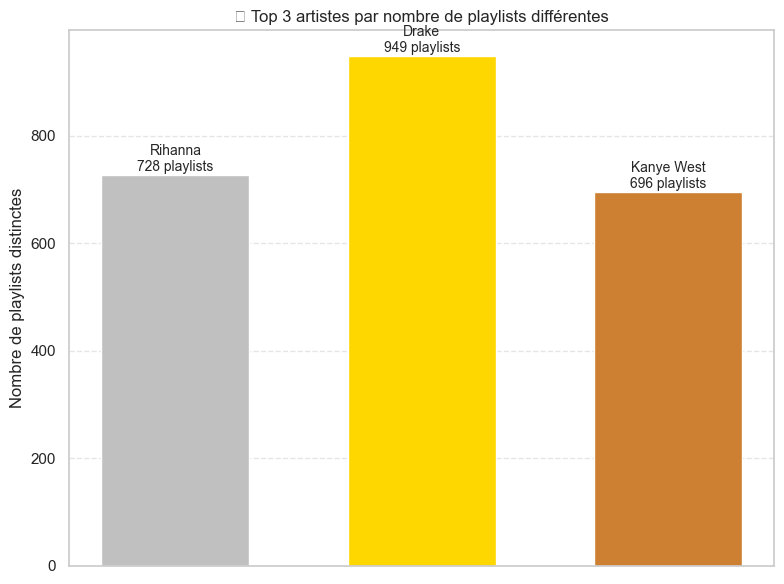

In [ ]:
# Nombre de playlists différentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

# Données du podium
scores = artist_playlist_counts.values
labels = artist_playlist_counts.index

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e à gauche, 2 = 3e à droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalisées (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libellés)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("🏆 Top 3 artistes par nombre de playlists différentes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

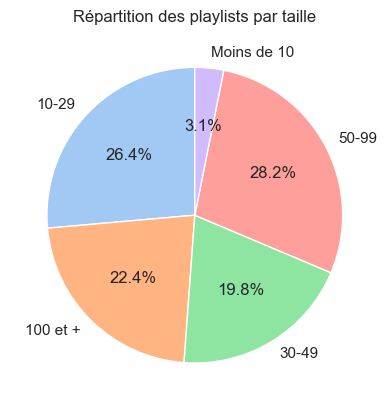

In [ ]:
def classify_playlist_size(n):
    if n < 10:
        return 'Moins de 10'
    elif n < 30:
        return '10-29'
    elif n < 50:
        return '30-49'
    elif n < 100:
        return '50-99'
    else:
        return '100 et +'

df['playlist_size'] = df.groupby('pid')['track_uri'].transform('count')
playlist_size_class = df[['pid', 'playlist_size']].drop_duplicates()
playlist_size_class['taille_cat'] = playlist_size_class['playlist_size'].apply(classify_playlist_size)

# Camembert
size_counts = playlist_size_class['taille_cat'].value_counts().sort_index()
size_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Répartition des playlists par taille")
plt.ylabel('')
plt.show()

C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\134669919.py:17: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\134669919.py:17: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\giorg\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9201 (\N{STOPWATCH}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\giorg\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


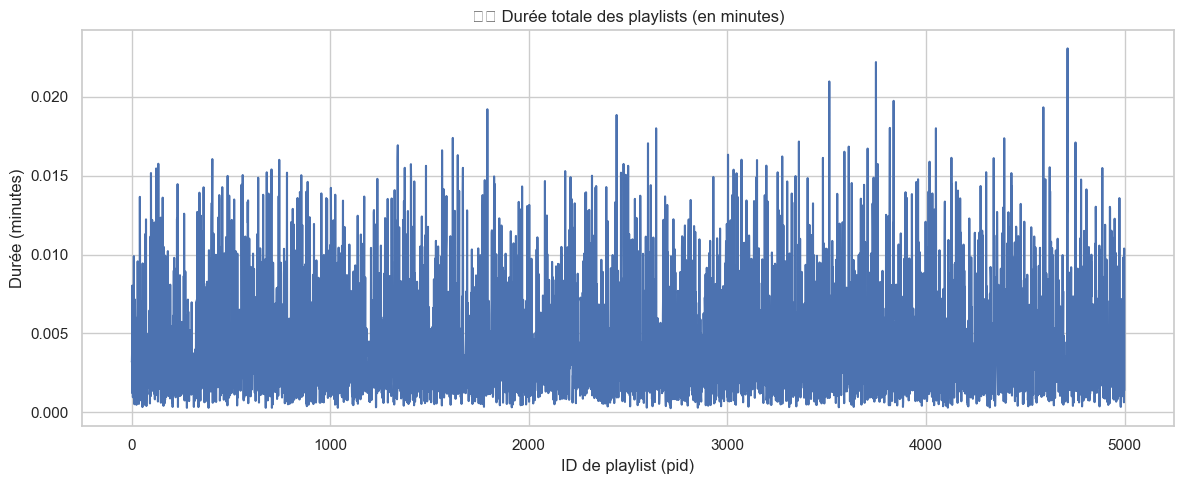

In [ ]:
# 1. Durée totale par playlist
duration_per_playlist = df.groupby('pid')['track_duration_minutes'].sum().reset_index()

# 2. Conversion en minutes
duration_per_playlist['duration_minutes'] = duration_per_playlist['track_duration_minutes'] / 60000

# 3. Tri des playlists par ID ou durée
duration_per_playlist = duration_per_playlist.sort_values('pid')  # ou .sort_values('duration_minutes')

# 4. Diagramme en ligne
plt.figure(figsize=(12, 5))
sns.lineplot(data=duration_per_playlist, x='pid', y='duration_minutes')
plt.title("⏱️ Durée totale des playlists (en minutes)")
plt.xlabel("ID de playlist (pid)")
plt.ylabel("Durée (minutes)")
plt.grid(True)
plt.tight_layout()
plt.show()

## Angel

"Les playlists avec plus de morceaux ont également plus d'artistes différents."

C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\787793120.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique["taille_classe"] = pd.cut(


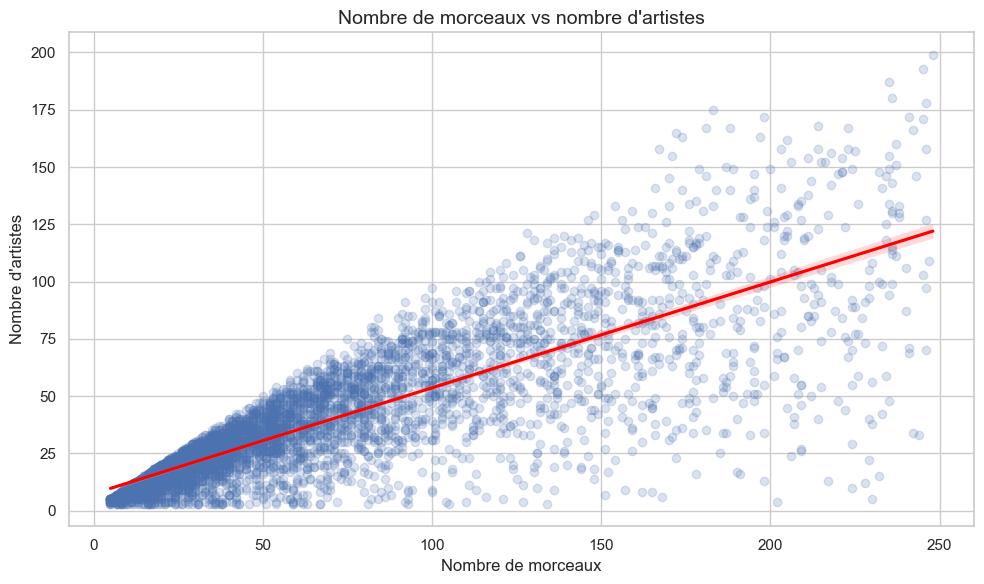

C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\787793120.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_unique, x="taille_classe", y="num_artists", palette="pastel")


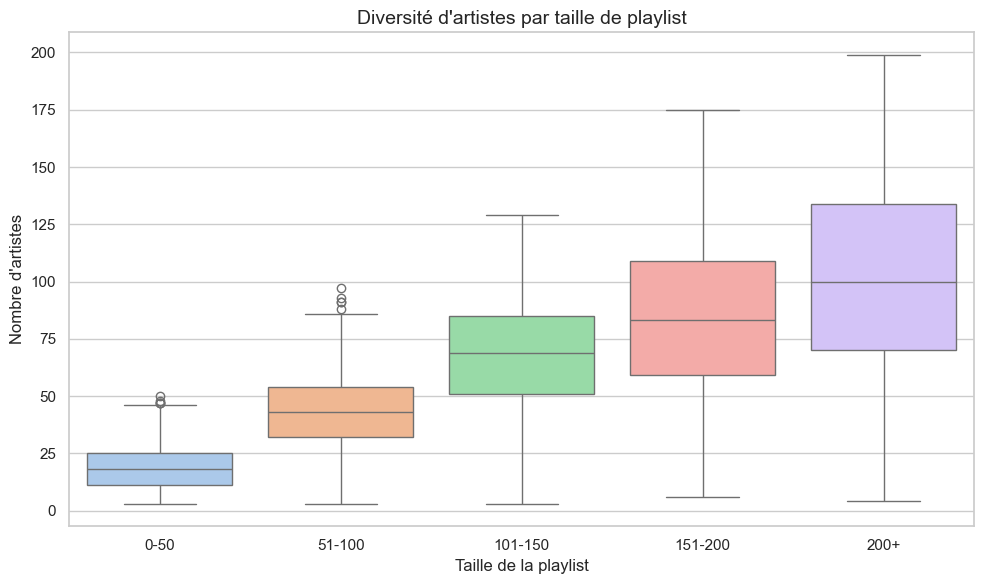

C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\787793120.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_artists = df_unique.groupby("taille_classe")["num_artists"].mean().reset_index()
C:\Users\giorg\AppData\Local\Temp\ipykernel_15700\787793120.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_artists, x="taille_classe", y="num_artists", palette="Blues_d")


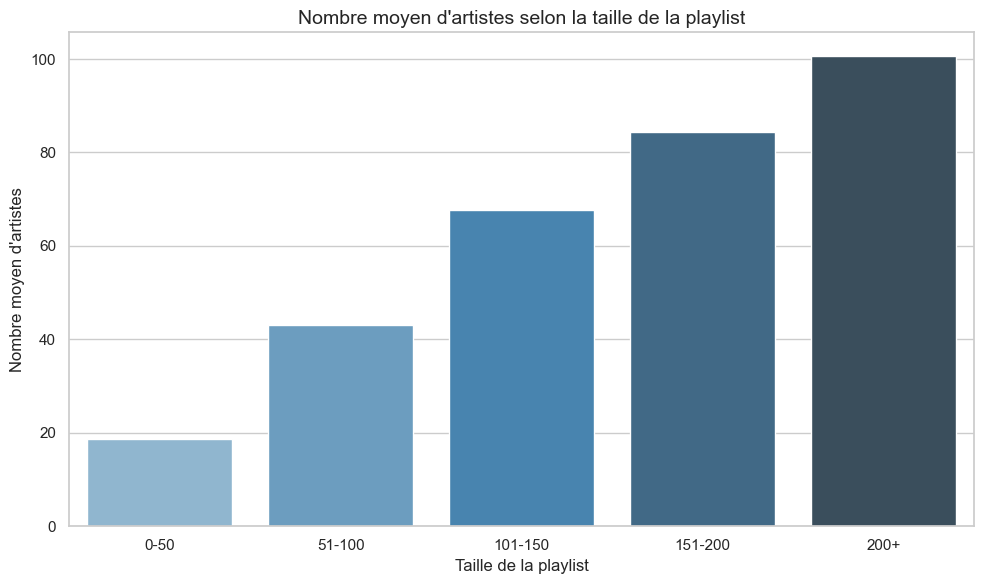

In [ ]:
df = pd.read_csv(cleaned_data_path, encoding="latin1", sep=None, engine="python")

df_unique = df.drop_duplicates(subset="pid")

df_unique["taille_classe"] = pd.cut(
    df_unique["num_tracks"],
    bins=[0, 50, 100, 150, 200, 1000],
    labels=["0-50", "51-100", "101-150", "151-200", "200+"]
)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.regplot(data=df_unique, x="num_tracks", y="num_artists", scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
plt.title("Nombre de morceaux vs nombre d'artistes et regression associé", fontsize=14)
plt.xlabel("Nombre de morceaux")
plt.ylabel("Nombre d'artistes")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_unique, x="taille_classe", y="num_artists", palette="pastel")
plt.title("Diversité d'artistes par taille de playlist", fontsize=14)
plt.xlabel("Taille de la playlist")
plt.ylabel("Nombre d'artistes")
plt.tight_layout()
plt.show()

mean_artists = df_unique.groupby("taille_classe")["num_artists"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(data=mean_artists, x="taille_classe", y="num_artists", palette="Blues_d")
plt.title("Nombre moyen d'artistes selon la taille de la playlist", fontsize=14)
plt.xlabel("Taille de la playlist")
plt.ylabel("Nombre moyen d'artistes")
plt.tight_layout()
plt.show()

## Giorgio
### Hypothèse : "plus d'artistes = plus de followers"

In [ ]:
df = pd.read_csv(cleaned_data_path, encoding="latin1", sep=None, engine="python")
df = df[['name', 'num_followers', 'num_artists']].drop_duplicates()
df = 

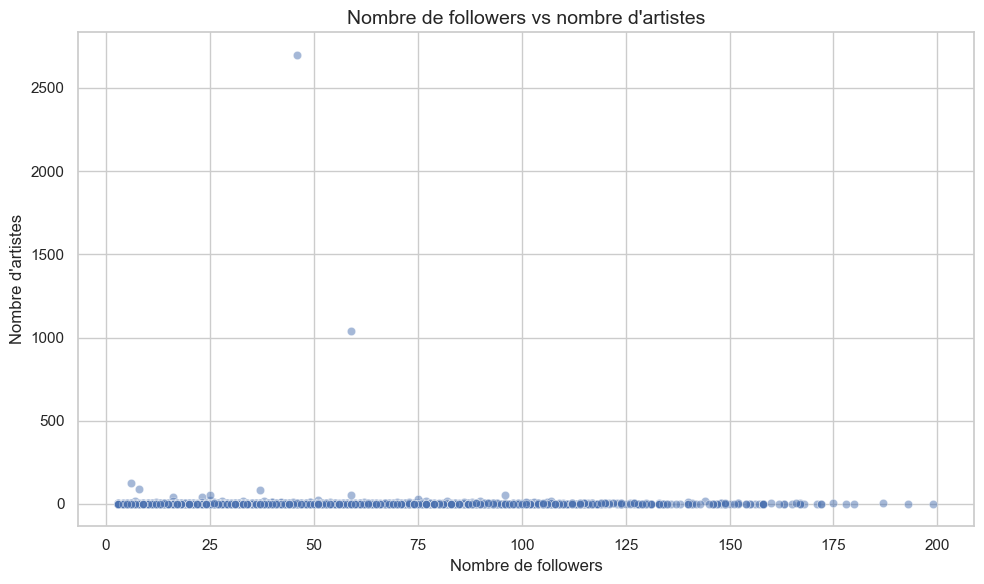

In [ ]:
def plot_followers_vs_artists(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='num_artists', y='num_followers', alpha=0.5)
    plt.title("Nombre de followers vs nombre d'artistes", fontsize=14)
    plt.xlabel("Nombre de followers")
    plt.ylabel("Nombre d'artistes")
    plt.tight_layout()
    plt.show()
    
plot_followers_vs_artists(df)

In [ ]:
df.describe()

,num_followers,num_artists
count,4921.000000,4921.000000
mean,2.366795,38.500102
std,41.315514,30.304519
min,1.000000,3.000000
25%,1.000000,16.000000
50%,1.000000,30.000000
75%,2.000000,52.000000
max,2699.000000,199.000000


Cette première analyse est insatesfaisante et en regardant dans les statistiques nous remarquons qu'il y a trop de playlist avec un nombre très limitées de chansons. Très possiblement, ces sont les playlist crée par les utilisateurs eux meme et que donc ont presque seulement eux commem followers.

Je vais donc chercher de pusser les limites et charger plus de playlist pour faire une analyse plus comprehensive

--- Début du nettoyage et chargement ---
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.0-999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.1000-1999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.10000-10999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.11000-11999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.12000-12999.json
Chargement d

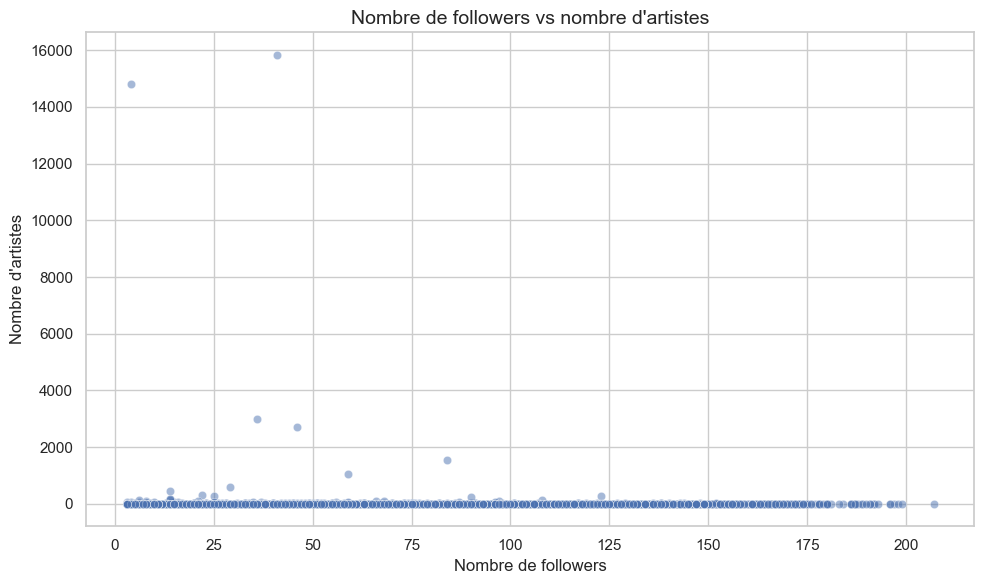

In [ ]:
df = write_csv_data_from_json(source_data_path, cleaned_data_path, number_of_files_limit=30)
df = df[['name', 'num_followers', 'num_artists']].drop_duplicates()

plot_followers_vs_artists(df)

In [ ]:
df.describe()


,num_followers,num_artists
count,28018.000000,28018.000000
mean,3.068099,39.133628
std,132.389545,30.848564
min,1.000000,3.000000
25%,1.000000,16.000000
50%,1.000000,31.000000
75%,2.000000,53.000000
max,15842.000000,207.000000


Nous commencons à nous rapprocher un peu, mais c'est toujours pas suffisant pour avoir une idée complete.
Je vais donc refaire la fonction de nettoyage pour mon cas spécifique pour essayer de prendre tout le million de playlist sans aplatir sur le niveau chanson (que dans le cas d'analyse de cette hypothèse n'est pas nécessaire)

In [ ]:
def load_only_playlists(source_data_path, cleaned_data_path, number_of_files_limit = 5):
    print("--- Début du nettoyage et chargement ---")
    
    # Chargement et fusion des données
    # base_dir = os.path.dirname(os.path.abspath(__file__)) # cette version est pour le .py

    # Chargement des fichiers JSON
    json_files = glob.glob(os.path.join(source_data_path, 'mpd.slice.*.json'))
    all_playlists = []
    mpd_df = 0
    for file in json_files[0:number_of_files_limit]:
        print(f"Chargement du file {file}")
        with open(file, 'r') as f:
            data = json.load(f)

            if mpd_df == 0:
                # Si c'est le premier fichier, on initialise mpd_df
                mpd_df = pd.DataFrame(data['playlists'])[["name", "num_followers", "num_artists"]]
            else:
                # Sinon, on concatène les données
                mpd_df = pd.concat(
                    [
                        mpd_df
                        , pd.DataFrame(data['playlists'])[["name", "num_followers", "num_artists"]]
                    ]
                    , ignore_index=True
                )

            all_playlists.extend(data['playlists'])

    print(f"Chargement de {len(all_playlists)} playlists")

    # Aplatissement des données (une ligne par piste)
    if all_playlists:

        mpd_df = pd.DataFrame(all_playlists)
        mpd_df = mpd_df[["name", "num_followers", "num_artists"]]
        df = mpd_df
    else:
        raise ValueError("Aucune playlist n'a été chargée. Vérifiez les fichiers JSON.")
    
    # Nettoyage des données
    print("\nÉtape 3: Début du nettoyage des données.")

    #################################################################################################

    # Gestion des doublons
    print(f"Lignes avant suppression des doublons : {len(df)}")
    df.drop_duplicates(inplace=True)
    print(f"Lignes après suppression des doublons : {len(df)}")

    # #################################################################################################

    return df

df = load_only_playlists(source_data_path, cleaned_data_path, number_of_files_limit = 5)
df.head(5)

--- Début du nettoyage et chargement ---
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.0-999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.1000-1999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.10000-10999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.11000-11999.json
Chargement du file d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\projet\Reporting-Projet-Annuel\alcrowd\source_data/spotify_million_playlist_dataset/data\mpd.slice.12000-12999.json
Chargement d

,name,num_followers,num_artists
0,Throwbacks,1,37
1,Awesome Playlist,1,21
2,korean,1,31
3,mat,1,86
4,90s,2,16
